# Backbone

In this section we will again focus on our research space object. But this time our objective is to extract the backbone network

In [1]:
import networkx as nx
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.patheffects as path_effects

import sys
sys.path.append("../")
from MapSci.papers import papers
from MapSci.research_space import research_space

This time we want to use the intermediate areas to create a research space. As in [before](https://github.com/franciscogaluppo/science-of-science/blob/master/examples/2\)%20Research%20Space.ipynb), we will first load our papers object (this time using the 'intermediate' key). Note that we pass a dict that we didn't before. It maps from the specif field to its intermediate area. We will also initialize our research space object with the same key, passing our papers as a parameter.

In [2]:
areas = pd.read_pickle("../dataset/SJR/areas.pkl")
dict_area = areas[["Field", "Classification"]].set_index("Field").to_dict()["Classification"]

pp = papers("intermediate", dict_area)
maps = research_space("intermediate", pp)

We will create a similar dict, from intermediate area to macro area. But this one will be just for drawing (the colors), it won't affect the backbone extraction.

In [3]:
dict_area = areas[["Classification", "Subject area"]].set_index("Classification").to_dict()["Subject area"]
unique = areas["Subject area"].unique()
subs = {u: v for v,u in enumerate(sorted(unique))}

To extract the backbone you can just call ```maps.get_backbone(model, alpha=alpha)```. It returns a networx graph object. The function below also creates a nice plot. Besides the backbone, we also have edges greedy clusters: black edges for inter cluster links; and red edges for intra cluster links.

In [4]:
def draw_one(ax, init, end, alpha=0.05):
    # Get the model
    maps.compute(init, end, model="embedding")
    model = "embedding({}, {}, 0.1, 200)".format(init, end)
    
    # Labeling objects
    fields = maps.phi[model][1].keys()
    values = [subs[dict_area[node]] for node in fields]
    trans = {str(x):values[x] for x in range(27)}
    ffs = [x if x != 'chemical engineering' else 'CENG' for x in fields]
    t = {str(x):ffs[x][:4].upper() for x in range(27)}
    
    # Get the backbone
    bb = maps.get_backbone(model, alpha=alpha)
    for node in [str(x) for x in range(27)]:
        if node not in bb.nodes:
            bb.add_node(node)
    
    # Color map and edge colors
    cm = cmx.get_cmap('viridis', 4)
    v = [cm(trans[x]/3) for x in bb.nodes]
    edges,weights = zip(*nx.get_edge_attributes(bb,'weight').items())
    weights = ['black' if x == 1 else 'red' for x in weights]
    
    # Chesterson's Fence
    pos = {str(x):((np.random.rand(), np.random.rand()) if t[str(x)] not in ['AGRI', 'BIOC', 'VETE', 'MULT'] else (10*np.random.rand(),10*np.random.rand())) if t[str(x)] not in ['HEAL', 'EART', 'ENVI'] else (-10*np.random.rand(),-10*np.random.rand()) for x in range(27)}
    pos = nx.kamada_kawai_layout(bb, pos=pos)
    
    # Draw the nodes
    print("Number of edges:", len(bb.edges))
    nx.draw(bb, node_color=v, edgelist=edges, edge_color=weights,
            node_size=250, width=0.5, pos=pos, ax=ax)
    
    # Draw the labels
    for x in range(27):
        xs = str(x)
        text = ax.text(pos[xs][0]-0.029, pos[xs][1]-0.016, t[xs], color="white", fontweight='bold',
                       fontname="Arial Black", family="monospace", size=7)
        text.set_path_effects([path_effects.withSimplePatchShadow(alpha=1, offset=(1,-1))])
    
    
    ax.set_title("Years {}-{}".format(init, end), size=12, weight='bold')

Let's see how good the plot is!

embedding(2003, 2007, 0.1, 200)
Number of edges: 65
embedding(2008, 2012, 0.1, 200)
Number of edges: 60
embedding(2012, 2016, 0.1, 200)
Number of edges: 54


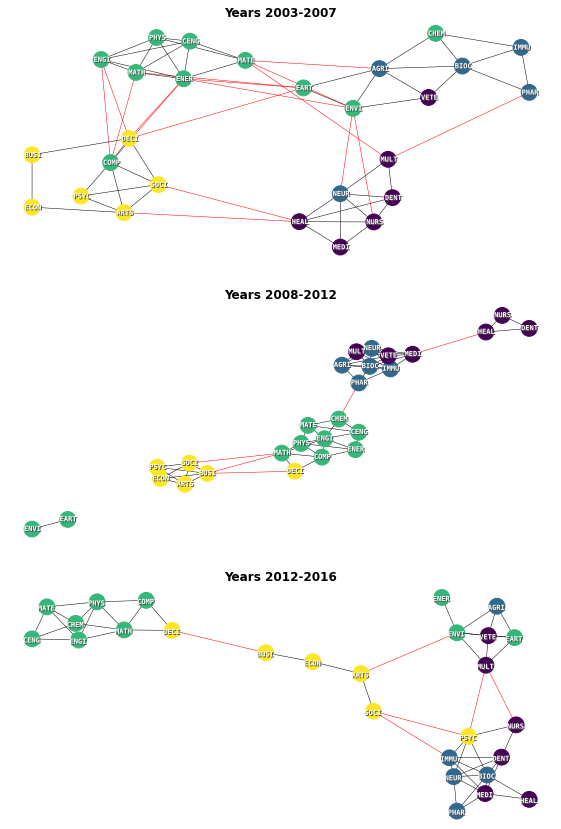

In [5]:
init = [2003, 2008, 2012]
plt.rcParams["figure.figsize"] = (9.8,14.7)

for i in range(len(init)):
    ini = init[i]
    ax = plt.subplot(3,1,i+1)
    draw_one(ax, ini, ini+4, 0.2)
    
plt.show()